# Importing Required Libraries


In [272]:
import numpy as np
import pandas as pd
import nltk
import gensim.downloader as api
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Loading the dataset


In [273]:
train = pd.read_csv("./Data/train.csv")
test = pd.read_csv("./Data/test.csv")

# EDA


In [274]:
columns = train.columns
columns

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

In [275]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [276]:
train.describe(include="object")

,keyword,location,text
count,7552,5080,7613
unique,221,3341,7503
top,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of T...
freq,45,104,10


In [277]:
train.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


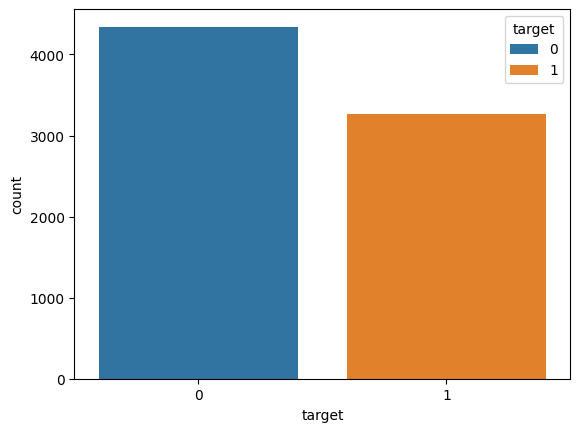

In [278]:
sns.countplot(train, x="target", hue="target");

# Data Preprocessing


## Drop duplicates text and Drop text with conflict target


In [279]:
train[train.text.duplicated()].groupby("text").apply(lambda x: x).drop(
    "text", axis=1
).head()

id         keyword  \
text                                                                            
#Allah describes piling up #wealth thinking it ... 4299  6105        hellfire   
                                                   4312  6123        hellfire   
#Bestnaijamade: 16yr old PKK suicide bomber who... 6366  9098  suicide%20bomb   
                                                   6373  9107  suicide%20bomb   
                                                   6377  9113  suicide%20bomb   

                                                                           location  \
text                                                                                  
#Allah describes piling up #wealth thinking it ... 4299  ?????? ??? ?????? ????????   
                                                   4312          ?????? ???? ??????   
#Bestnaijamade: 16yr old PKK suicide bomber who... 6366                     Nigeria   
                                                   6373                     Nigeria   
                                                   6377                     Nigeria   

                                                         target  
text                                                             
#Allah describes piling up #wealth thinking it ... 4299       0  
                                                   4312       1  
#Bestnaijamade: 16yr old PKK suicide bomber who... 6366       1  
                                                   6373       1  
                                                   6377       1

In [280]:
print(f"{train.text.duplicated().sum()/len(train)*100:0.2f}%")

1.44%


In [281]:
# Store duplicated text
duplicated = train.text.duplicated()

# convert dtype of target to float (to store 0.5 which indicates text with conflict target)
train.target = train.target.astype(np.float16)

# compute median target for each group
median_target = train.groupby("text").target.transform("median")

# update target by median_target
train.loc[:, "target"] = median_target

# drop duplicated text with conflict target (median_target = 0.5)
train = train[median_target != 0.5]

# drop duplicated text and keep one
train.drop_duplicates(subset="text", keep="first", inplace=True)

# return the dtype of target to int
train.target = train.target.astype(np.int8)

In [282]:
train[duplicated].groupby("text").apply(lambda x: x).drop("text", axis=1)

C:\Users\mmria\AppData\Local\Temp\ipykernel_9988\1298107107.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train[duplicated].groupby("text").apply(lambda x: x).drop("text", axis=1)


,id,keyword,location,target
text,,,,


## Clean the tweet text
by removing noise such as special characters, URLs, and HTML tags.

In [283]:
def clean_text(sent: str) -> str:
    # sub url
    sent = re.sub("http.*? ", "", sent)
    # sub html tags
    sent = re.sub("<.*?>", "", sent)
    # sub special characters
    sent = re.sub("[^a-zA-Z]", " ", sent)
    return sent


train.text = train.text.apply(clean_text)

## Normalize the text
by converting to lowercase, removing stopwords, and applying stemming or lemmatization.

In [284]:
# another way to remove stopwords using numpy
stop = ["i", "am"]
sent = "I am from Jordan"
sent = sent.lower()
sent = np.array(nltk.tokenize.word_tokenize(sent))
not_in_stop = ~np.isin(sent, stop)
sent = sent[not_in_stop]
sent = " ".join(sent)
print(sent)

from jordan


In [285]:
# POS
# -----------------------
# n: noun
# v: verb
# a: adjective
# r: adverb
# s: satellite adjectives


def get_wordnet_pos(treebank_tag: str) -> str:
    if treebank_tag.startswith("J"):
        return "a"
    elif treebank_tag.startswith("V"):
        return "v"
    elif treebank_tag.startswith("N"):
        return "n"
    elif treebank_tag.startswith("R"):
        return "r"
    else:
        return ""


def lemma(sent: str) -> str:
    wnl = nltk.stem.WordNetLemmatizer()
    sent = nltk.pos_tag(sent)
    sent = [(w, get_wordnet_pos(p)) for w, p in sent]
    sent = [wnl.lemmatize(w, p) if p != "" else w for w, p in sent]

    return sent

In [286]:
english_stopwords = nltk.corpus.stopwords.words("english")
english_stopwords.remove("not")


def normalize_text(sent: str) -> str:
    # convert to lowercase
    sent = sent.lower()
    # removing stopwords
    sent = [
        word
        for word in nltk.tokenize.word_tokenize(sent)
        if word not in english_stopwords
    ]
    # applying lemmatization
    sent = lemma(sent)
    sent = " ".join(sent)
    return sent


train.text = train.text.apply(normalize_text)

## Tokenize the text 
to convert sentences into individual words or tokens for further analysis.

In [294]:
# word tokenize
train.text = train.text.apply(nltk.tokenize.word_tokenize)

# Feature Extraction

## Employ TF-IDF or word embeddings 
to convert text data into a numerical format that can be processed by machine learning models.
 

In [ ]:
# TF-IDF

# Word embeddings

## Consider extracting additional features 
from the tweets, like tweet length or specific keywords.


In [ ]:
# tweet length

# specific keywords